In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

In [10]:
with open('../../genIII_data/JLab/Beam/1-63-60-Beam-Cal.pkl', 'rb') as file:
    # Load the data from the pickle file
    din = pickle.load(file)
with open("geometry.pkl", 'rb') as file:
    geometry = pickle.load(file)

In [6]:
def get_energy_at_z(beam_lg_mips, z_target, tol=1e-6):
    lg_mips_at_z = []

    for event in beam_lg_mips:
        for entry in event:
            lg_mip, x, y, z = entry
            if abs(z - z_target) < tol and lg_mip > 0:
                lg_mips_at_z.append(lg_mip)

    return lg_mips_at_z


In [12]:
# Step 1: Get unique sorted z values
z_values_sorted = sorted(geometry["z"].unique())  # ascending order

# Step 2: Build the list of arrays
energy_by_layer = []
for z in z_values_sorted:
    energy = get_energy_at_z(din, z)
    energy_by_layer.append(np.array(energy))

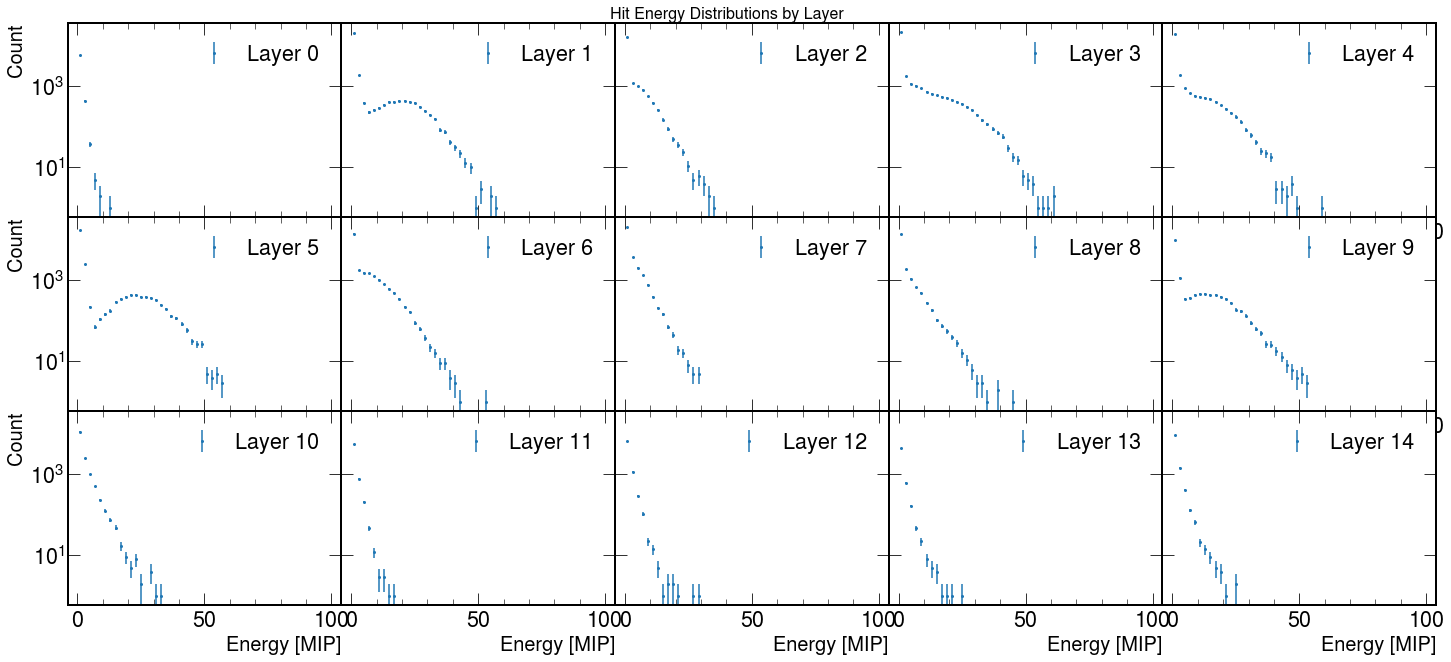

In [28]:
configure_plotting()
# Assuming mips_by_layer is already defined from earlier
num_layers = len(energy_by_layer)
cols = 5  # You can change this layout
rows = (num_layers + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharey=True)
axes = axes.flatten()

# Histogram settings
bins = 50
range_ = (0, 100)

for i, data in enumerate(energy_by_layer):
    counts, bin_edges = np.histogram(data, bins=bins, range=range_)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)

    ax = axes[i]
    ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2, label=f'Layer {i}')
    ax.set_yscale("log")
    ax.legend()
    for ax in axes[-5:]:  # Bottom row (x-axis label)
        ax.set_xlabel("Energy [MIP]", fontsize=20)
    
    for ax in axes[::5]:  # Left column (y-axis label)
        ax.set_ylabel("Count", fontsize=20)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Hit Energy Distributions by Layer", fontsize=16, y=1.0)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [23]:
num_events = din.shape[0]
z_values_sorted = sorted(geometry["z"].unique())
num_layers = len(z_values_sorted)

# Map z -> layer index
z_to_layer_idx = {z: i for i, z in enumerate(z_values_sorted)}

# Initialize array: (num_events, num_layers)
layer_sums = np.zeros((num_events, num_layers))

for evt_idx, event in enumerate(din):
    for energy, x, y, z in event:
        if energy > 0:
            layer_idx = z_to_layer_idx[z]
            layer_sums[evt_idx, layer_idx] += energy


/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


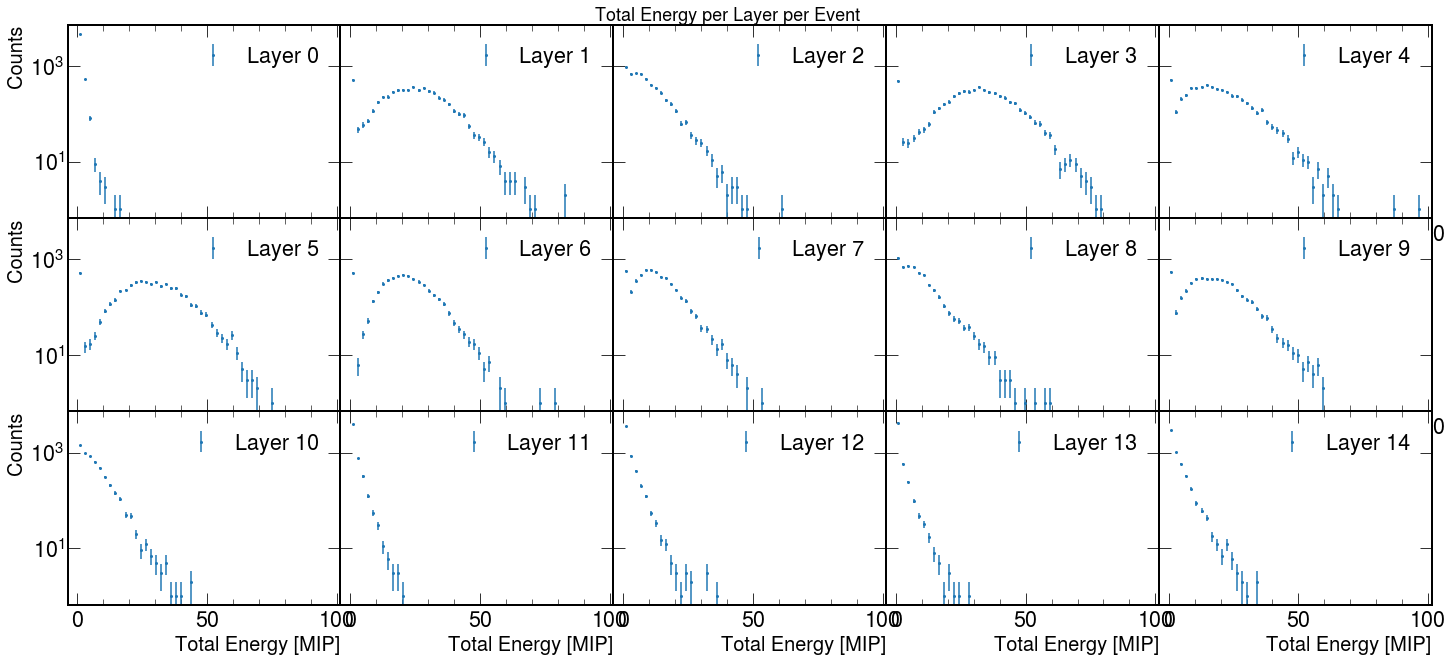

In [27]:
cols = 5
rows = (num_layers + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharey = True)
axes = axes.flatten()

bins = 50
range_ = (0, layer_sums.max())

for i in range(num_layers):
    data = layer_sums[:, i]
    counts, bin_edges = np.histogram(data, bins=bins, range=range_)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)

    ax = axes[i]
    ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2, label=f'Layer {i}')
    ax.set_yscale('log')
    ax.legend()

# Label only bottom row and left column
for ax in axes[-cols:]:
    ax.set_xlabel("Total Energy [MIP]", fontsize=20)
for ax in axes[::cols]:
    ax.set_ylabel("Counts", fontsize=20)

# Hide unused axes
for ax in axes[num_layers:]:
    ax.axis("off")

plt.suptitle("Total Energy per Layer per Event", fontsize=18, y=1.0)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
